## Script to train a neural network

This script run the training of a neural networks.
For long training, it is advised to used this script as a python script, not the notebook

In [2]:
import numpy as np
import os
from os.path import join,isdir
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from neuralsw.model.modeltools import mymodel,loadmymodel
from keras import regularizers
from keras.optimizers import SGD
import glob
import warnings
import matplotlib.pyplot as plt

/Users/brajard/anaconda/envs/nn/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
# Initialize parameters
PLOT = True
SAVE = True #to save plots
#rootdir
rootdir = os.path.realpath(\
    os.path.join(os.getcwd(),'../..'))

#directory to store the data
datadir = os.path.realpath(os.path.join(rootdir,'data'))

#training directory
#traindir = 'train_uparam_nonoise_std'
#traindir = 'train_uparam_noise01_std'
traindir = 'train_vparam_nonoise_std'
#traindir = 'train_vparam_noise01_std'

#First guess net
#fgnet = None
fgnet_id = None

#neural net identifier (to personalize the output name)
nnid = '0'

keywords = traindir.split('_')

#param
param = keywords[1]

#files containing inputs/outputs
Xfile = join(datadir,traindir,'data_X.npy')
yfile = join(datadir,traindir,'data_y.npy')

#input name
if fgnet_id is not None:
    fgnet = '_'.join(['nn'+fgnet_id,param,keywords[2],keywords[3]])

    #Raise warnings if there are some issues with the selected names
    if not os.path.isdir(join(datadir,fgnet)):
        warnings.warn(join(datadir,fgnet) +' does not exist')
    print('first guess neural net:',fgnet)

    if fgnet_id == nnid:
        warnings.warn ('first guess and output have the same id')

#output name
netname = '_'.join(['nn'+nnid,param,keywords[2],keywords[3]])
print('output name of the neural net:',netname)


output name of the neural net: nn0_vparam_nonoise_std


In [11]:
## Load the data
X = np.load(Xfile)
y = np.load(yfile)
nt,ny,nx,npar = X.shape



In [12]:
## Define the nn model
if fgnet_id is not None:
    pklfile=glob.glob(join(datadir,fgnet,'*.pkl'))[0]
    nn = loadmymodel(pklfile)
else:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',
              padding='same',
              #kernel_regularizer=regularizers.l1(0.001),
              input_shape=(ny, nx, npar)))
    #model.add(Dropout(0.2))
    model.add(Conv2D(1, (1, 1), activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    #normalization
    moy = np.zeros(npar)
    et = np.zeros(npar)
    for j in range(npar):
            moy[j] = np.mean(X[:,:,:,j].ravel())
            et[j] = np.std(X[:,:,:,j].ravel())
          
    moy_y = np.mean(y.ravel())
    et_y = np.std(y.ravel())
        
    nn = mymodel(model,moyX=moy,etX=et,moyY=moy_y,etY=et_y)




In [13]:
## Training
nn.fit(X, y, epochs=200, batch_size=1,validation_split=0.1)

Train on 432 samples, validate on 48 samples
Epoch 1/200
432/432 [==============================] - 5s 11ms/step - loss: 0.0467 - val_loss: 0.0065
Epoch 2/200
432/432 [==============================] - 5s 12ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/200
432/432 [==============================] - 5s 11ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/200
432/432 [==============================] - 4s 10ms/step - loss: 0.0011 - val_loss: 7.8887e-04
Epoch 5/200
432/432 [==============================] - 4s 10ms/step - loss: 5.6587e-04 - val_loss: 3.7242e-04
Epoch 6/200
432/432 [==============================] - 4s 10ms/step - loss: 2.7716e-04 - val_loss: 2.0066e-04
Epoch 7/200
432/432 [==============================] - 4s 10ms/step - loss: 1.6298e-04 - val_loss: 1.2863e-04
Epoch 8/200
432/432 [==============================] - 4s 10ms/step - loss: 1.1233e-04 - val_loss: 9.3889e-05
Epoch 9/200
432/432 [==============================] - 4s 10ms/step - loss: 8.3733e-05 - val_loss: 7.08

Epoch 75/200
432/432 [==============================] - 5s 11ms/step - loss: 6.1347e-06 - val_loss: 6.3039e-07
Epoch 76/200
432/432 [==============================] - 3s 7ms/step - loss: 7.7510e-06 - val_loss: 2.4326e-05
Epoch 77/200
432/432 [==============================] - 3s 7ms/step - loss: 1.9672e-06 - val_loss: 6.8200e-07
Epoch 78/200
432/432 [==============================] - 3s 7ms/step - loss: 1.1744e-06 - val_loss: 1.6277e-06
Epoch 79/200
432/432 [==============================] - 4s 8ms/step - loss: 3.7408e-06 - val_loss: 6.3010e-07
Epoch 80/200
432/432 [==============================] - 3s 6ms/step - loss: 5.1176e-06 - val_loss: 9.8944e-07
Epoch 81/200
432/432 [==============================] - 3s 6ms/step - loss: 7.4163e-06 - val_loss: 5.6229e-07
Epoch 82/200
432/432 [==============================] - 3s 6ms/step - loss: 1.2815e-06 - val_loss: 7.7061e-06
Epoch 83/200
432/432 [==============================] - 3s 6ms/step - loss: 2.3556e-06 - val_loss: 1.0391e-06
Epoch 84/

Epoch 149/200
432/432 [==============================] - 2s 6ms/step - loss: 8.0028e-06 - val_loss: 6.5724e-07
Epoch 150/200
432/432 [==============================] - 3s 7ms/step - loss: 2.8122e-07 - val_loss: 2.2751e-07
Epoch 151/200
432/432 [==============================] - 4s 8ms/step - loss: 4.1754e-06 - val_loss: 3.3304e-06
Epoch 152/200
432/432 [==============================] - 4s 10ms/step - loss: 7.1742e-07 - val_loss: 1.6157e-06
Epoch 153/200
432/432 [==============================] - 4s 9ms/step - loss: 4.0724e-06 - val_loss: 2.1740e-07
Epoch 154/200
432/432 [==============================] - 3s 6ms/step - loss: 4.2799e-06 - val_loss: 1.0706e-06
Epoch 155/200
432/432 [==============================] - 2s 6ms/step - loss: 8.5510e-07 - val_loss: 2.3039e-07
Epoch 156/200
432/432 [==============================] - 2s 6ms/step - loss: 3.1076e-06 - val_loss: 2.1218e-07
Epoch 157/200
432/432 [==============================] - 2s 6ms/step - loss: 1.7442e-06 - val_loss: 3.3417e-06


In [14]:
## Save the neural net
if not isdir(join(datadir, netname)):
    os.mkdir(join(datadir, netname))
nn.save(join(datadir,netname,'model_'+param+'.pkl'))


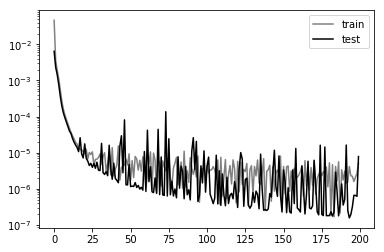

In [15]:
## Plots and save
if PLOT:
    #plot history
    plt.semilogy(nn._history['loss'], color='gray',label='train')
    plt.semilogy(nn._history['val_loss'], color='black',label='test')
    plt.legend()
    if SAVE:
        plt.savefig(join(datadir, netname, 'history.png'))
    plt.show()
    

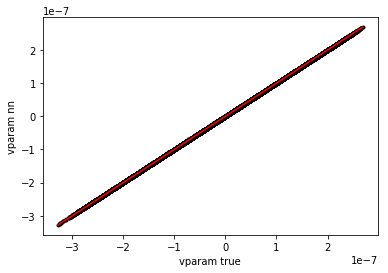

In [16]:
## a small scatter plot to check
mini = min(y.ravel())
maxi = max(y.ravel())

y_predict = nn.predict(X)
plt.plot(y.ravel(),y_predict.ravel(),'.k')
plt.plot([mini,maxi],[mini,maxi],'r-')
plt.xlabel(param + ' true')
plt.ylabel(param + ' nn')
plt.show()